In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [92]:

DIVIDEND = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_DATA_HISTORICAL_DIVIDEND.csv")
SCORE = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_ETF_SOR_IFO.csv")
ETF_Hoding = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_DATA_ETF_HOLDINGS.csv")
CUSTOMER = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NHDATA_CUS_TP_IFO.csv")
INCOME_Outcome_Flow = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NHDATA_IFW_OFW_IFO.csv")
DAY_Data = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NHDATA_STK_DD_IFO.csv")
STOCK_Explane = pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_NW_FC_STK_IEM_IFO.csv")
OHLCV= pd.read_csv("/Users/sonhyeongjin/Desktop/github/Data/NH_CONTEST_STK_DT_QUT.csv")


In [93]:


# tck_iem_cd 컬럼에서 앞뒤 공백 제거
CUSTOMER['tck_iem_cd'] = CUSTOMER['tck_iem_cd'].str.strip()


# 기본적인 EDA방법은 종단면과 횡단면으로 구분한다

-----

# CUSTOMER

기준일자, 티커종목코드, 고객구성대분류코드, 고객구성중분류코드, 고객구성계좌수비율, 고객구성투자비율

In [3]:
sorting_day = CUSTOMER['bse_dt'].value_counts().sort_index() 
#날짜 기준으로 묶을 필요가 있음
#sorting_day를 사용해서 하루하루 날짜 인덱싱 할 예정
sorting_day

bse_dt
20240528    18799
20240529    18796
20240530    18829
20240531    18845
20240603    18920
            ...  
20240820    19005
20240821    19024
20240822    19021
20240823    19058
20240826    19051
Name: count, Length: 63, dtype: int64

## 횡단면 분석
시간축을 고정하여 분석

In [50]:
cross_sample = CUSTOMER[CUSTOMER['bse_dt'] ==sorting_day.index[0]] #가장 첫날을 기준으로 확인
cross_sample_ticker =  cross_sample['tck_iem_cd'].value_counts()
cross_sample_llf = cross_sample['cus_cgr_llf_cd'].value_counts()
cross_sample_mlf = cross_sample['cus_cgr_mlf_cd'].value_counts()
cross_sample

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
206,20240528,AAL,2,22,37.9140,33.2190
207,20240528,AAL,2,23,23.5249,18.8676
210,20240528,AAL,2,24,12.5238,20.8803
211,20240528,AAL,2,25,4.5299,15.3642
212,20240528,AAL,2,21,21.5074,11.6688
...,...,...,...,...,...,...
1194588,20240528,ZS,3,34,3.2680,34.7522
1194593,20240528,ZS,3,33,33.3333,35.3987
1194594,20240528,ZS,3,31,37.2549,11.9073
1194886,20240528,ZS,1,12,98.0392,71.8211


In [51]:
AAL_Sample = cross_sample[cross_sample['tck_iem_cd'] == cross_sample_ticker.index[0]]
AAL_Sample

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
206,20240528,AAL,2,22,37.9140,33.2190
207,20240528,AAL,2,23,23.5249,18.8676
210,20240528,AAL,2,24,12.5238,20.8803
211,20240528,AAL,2,25,4.5299,15.3642
212,20240528,AAL,2,21,21.5074,11.6688
531,20240528,AAL,3,32,19.2615,29.5596
532,20240528,AAL,3,31,71.1077,27.8117
533,20240528,AAL,3,33,9.4024,40.4506
535,20240528,AAL,3,34,0.1903,2.1777
640,20240528,AAL,1,12,98.8199,97.4460


고객 구성 계좌 비율이 높으면 투자비율이 높을 확률이 크다. 계좌가 많다는 것은 투자를 많이 한다는 것임 그런데 계좌 비율이 높지 않은데 투자비율이 높은 분류가 존재할까? 
우리는 투자 계좌 비중이 작은데 투자 비중이 높은 그룹을 고래 그룹이라고 가정한다. 
1. 대분류 기준에서 봤을때 고래가 존재하는가? 
2. 중분류 기준에서 봤을때 고래가 존재하는가?
3. 종목간 차이가 있는가? 

In [55]:
cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)

# 순위 차이 계산
cross_sample['rank_difference_llf'] = cross_sample['act_cnt_rt_rank'] - cross_sample['ivs_rt_rank']

# 순위 차이가 양수이면 우리가 가정한 고래이다. (계좌 비율보다 투자비율이 높다)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/2389746522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/2389746522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_llf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2m

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt,act_cnt_rt_rank,ivs_rt_rank,rank_difference_llf
206,20240528,AAL,2,22,37.9140,33.2190,1619.0,2506.0,-887.0
207,20240528,AAL,2,23,23.5249,18.8676,4414.0,4319.0,95.0
210,20240528,AAL,2,24,12.5238,20.8803,6876.0,3992.0,2884.0
211,20240528,AAL,2,25,4.5299,15.3642,8510.0,4887.0,3623.0
212,20240528,AAL,2,21,21.5074,11.6688,4781.0,5546.0,-765.0
...,...,...,...,...,...,...,...,...,...
1194588,20240528,ZS,3,34,3.2680,34.7522,6070.5,2665.0,3405.5
1194593,20240528,ZS,3,33,33.3333,35.3987,2862.0,2618.0,244.0
1194594,20240528,ZS,3,31,37.2549,11.9073,2554.0,5050.0,-2496.0
1194886,20240528,ZS,1,12,98.0392,71.8211,1846.5,2335.0,-488.5


In [56]:
result = cross_sample.groupby('cus_cgr_llf_cd')['rank_difference_llf'].apply(lambda x: pd.Series({
    'positive_count': (x > 0).sum(),
    'negative_count': (x < 0).sum()
}))

# 결과 출력
print(result)

cus_cgr_llf_cd                
1               positive_count     900
                negative_count     900
2               positive_count    4239
                negative_count    4324
3               positive_count    3195
                negative_count    3042
Name: rank_difference_llf, dtype: int64


1번 대 분류 그룹은 순위 차이가 존재하지 않음 2번과 3번은 존재하는데 유의미한 차이는 아닌것 같음 

**특히 1번은 모든 순위가 동일함**

In [57]:
cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)

# 순위 차이 계산
cross_sample['rank_difference_mlf'] = cross_sample['act_cnt_rt_rank'] - cross_sample['ivs_rt_rank']

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/1503364756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/1503364756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['ivs_rt_rank'] = cross_sample.groupby('cus_cgr_mlf_cd')['cus_cgr_ivs_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2m

In [59]:
result = cross_sample.groupby('cus_cgr_mlf_cd')['rank_difference_mlf'].apply(lambda x: pd.Series({
    'positive_count': (x > 0).sum(),
    'negative_count': (x < 0).sum()
}))

# 결과 출력
print(result)

cus_cgr_mlf_cd                
11              positive_count     496
                negative_count     405
12              positive_count     405
                negative_count     496
21              positive_count     947
                negative_count     815
22              positive_count     981
                negative_count     957
23              positive_count    1040
                negative_count     849
24              positive_count     933
                negative_count     767
25              positive_count     685
                negative_count     589
31              positive_count     955
                negative_count     963
32              positive_count     873
                negative_count     939
33              positive_count     926
                negative_count     825
34              positive_count     421
                negative_count     327
Name: rank_difference_mlf, dtype: int64


중분류 간 차이는 거의 없는 거 같음

3. 종목간 차이가 있는가?

In [60]:
cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
cross_sample['ivs_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_ivs_rt'].rank(ascending=False)

# 순위 차이 계산
cross_sample['rank_difference_tick'] = cross_sample['act_cnt_rt_rank'] - cross_sample['ivs_rt_rank']

# 순위 차이가 양수이면 우리가 가정한 고래이다. (계좌 비율보다 투자비율이 높다)

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/3275228721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['act_cnt_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_act_cnt_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_15988/3275228721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_sample['ivs_rt_rank'] = cross_sample.groupby('tck_iem_cd')['cus_cgr_ivs_rt'].rank(ascending=False)
/var/folders/hy/_k7gcypd00s_2mmm5h2jkt

In [62]:
result = cross_sample.groupby('tck_iem_cd')['rank_difference_tick'].apply(lambda x: pd.Series({
    'positive_count': (x > 0).sum(),
    'negative_count': (x < 0).sum()
}))

# 결과 출력
print(result)

tck_iem_cd                  
AA            positive_count    4
              negative_count    5
AAL           positive_count    4
              negative_count    3
AAN           positive_count    3
                               ..
ZVRA          negative_count    6
ZYME          positive_count    4
              negative_count    3
ZYXI          positive_count    1
              negative_count    2
Name: rank_difference_tick, Length: 4764, dtype: int64


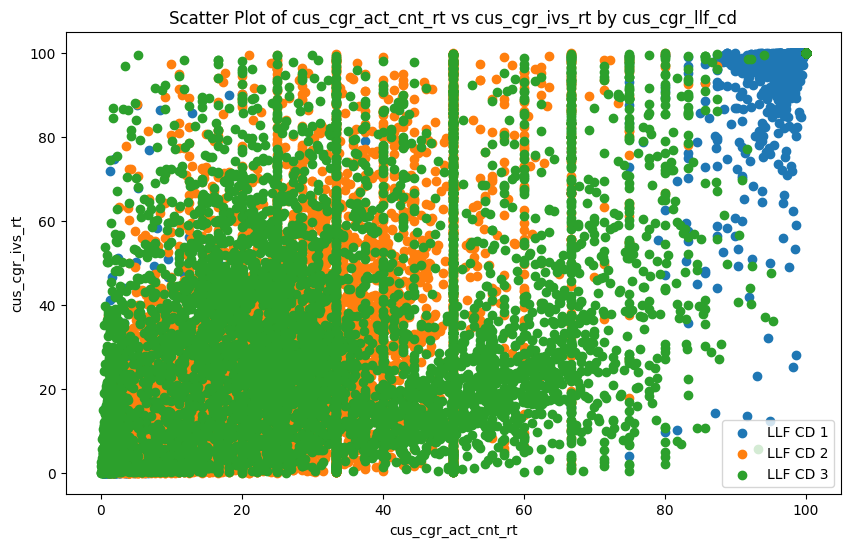

In [63]:
plt.figure(figsize=(10, 6))

# 다른 색으로 그룹별 구분
groups = cross_sample.groupby('cus_cgr_llf_cd')
for name, group in groups:
    plt.scatter(group['cus_cgr_act_cnt_rt'], group['cus_cgr_ivs_rt'], label=f'LLF CD {name}')

# 그래프 레이블 및 제목 설정
plt.xlabel('cus_cgr_act_cnt_rt')
plt.ylabel('cus_cgr_ivs_rt')
plt.title('Scatter Plot of cus_cgr_act_cnt_rt vs cus_cgr_ivs_rt by cus_cgr_llf_cd')
plt.legend()

# 그래프 출력
plt.show()

## 종단면 분석

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt,act_cnt_rt_rank,ivs_rt_rank,rank_difference
206,20240528,AAL,2,22,37.9140,33.2190,1619.0,2506.0,-887.0
207,20240528,AAL,2,23,23.5249,18.8676,4414.0,4319.0,95.0
210,20240528,AAL,2,24,12.5238,20.8803,6876.0,3992.0,2884.0
211,20240528,AAL,2,25,4.5299,15.3642,8510.0,4887.0,3623.0
212,20240528,AAL,2,21,21.5074,11.6688,4781.0,5546.0,-765.0
...,...,...,...,...,...,...,...,...,...
1194588,20240528,ZS,3,34,3.2680,34.7522,6070.5,2665.0,3405.5
1194593,20240528,ZS,3,33,33.3333,35.3987,2862.0,2618.0,244.0
1194594,20240528,ZS,3,31,37.2549,11.9073,2554.0,5050.0,-2496.0
1194886,20240528,ZS,1,12,98.0392,71.8211,1846.5,2335.0,-488.5


In [20]:
cross_sample['tck_iem_cd'] = 

-----

일단은 etf와 결합 가능한지 확인해본다
기본적인 아이디어는 llama3-8b모델을 활용해서 etf 추천을 하는 것이다.

그럼 eda를 어떻게 진행해야 될까

찾아야 될 내용

needs: 사람들은 ETF를 거시적인 관점에서 사용한다. 모든 사람들이 동일한 관점에서 ETF를 구매하지 않을 것이다. 즉. 여러개의 etf를 구매해서 자신만의 큰 뷰를 완성시키는 그러한 포트폴리오를 구성 할 것이다.

확인해야 될 내용은 다음과 같다. 

1. 사람들이 다양한 ETF를 구성하는가?

2. 비슷한 ETF를 구성한 사람들의 특징은 무었이 있을까? 

3. ETF를 제외한 추가적인 주식은 어떤것을 샀을까? 

=> 바라건데 사람들이 다양한 관점으로 ETF와 주식으로 포트폴리오를 만든다는 것을 알았다. 
하지만 비슷한 포트폴리오도 사람들마다 판단 기준이 매우 상이했다. 즉, 개인화된 서비스를 제공하는 것이 유의미 하다.

LLM모델을 통해서 개인화된 ETF+주식 포트폴리오 추천을 해준다

현재 상황을 자연어로 넣어준 후 ETF+주식을 추천해주는 것이다. 


## 1. 사람들이 다양한 ETF를 구성하는가?

In [86]:
import pandas as pd

# 고객이 보유한 ETF를 확인하는 함수
def count_etfs_per_user(customer_df):
    # ETF 데이터를 필터링 (종목 코드가 ETF인 경우만)
    # 종목 구분 코드가 'ETF'인 경우만 필터링 (데이터 구조에 따라 코드 수정 가능)
    etf_holdings = customer_df[customer_df['tck_iem_cd'].str.contains('etf')]

    # 각 유저가 들고 있는 ETF의 개수 세기 (기준: 고객 구성 대분류 코드 cus_cgr_llf_cd)
    etf_count_per_user = etf_holdings.groupby('cus_cgr_llf_cd')['tck_iem_cd'].nunique().reset_index()

    # 열 이름 변경 (알아보기 쉽게)
    etf_count_per_user.columns = ['user_id', 'number_of_etfs_held']

    return etf_count_per_user,etf_holdings

# 데이터 읽기 (CUSTOMER 데이터셋 로드)


# 함수 실행
etf_count_per_user,etf_holdings = count_etfs_per_user(CUSTOMER)

# 결과 출력
print(etf_count_per_user)

# 결과를 CSV로 저장하고 싶을 경우
# etf_count_per_user.to_csv('etf_count_per_user.csv', index=False)

Empty DataFrame
Columns: [user_id, number_of_etfs_held]
Index: []


In [87]:
etf_holdings

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt


In [88]:
import pandas as pd

# 고객이 보유한 ETF를 확인하는 함수
def count_unique_etfs_per_user(customer_df, etf_holding_df):
    # 고객이 보유한 종목 중 ETF만 필터링 (종목구분이 ETF인 경우)
    # 두 데이터셋을 조인하여 ETF 보유 데이터만 추출 (ETF_Holding의 etf_tck_cd와 CUSTOMER의 tck_iem_cd를 이용)
    etf_customers = pd.merge(customer_df, etf_holding_df[['etf_tck_cd', 'tck_iem_cd']], on='etf_tck_cd')

    # 각 유저가 들고 있는 ETF의 개수 세기 (기준: 고객 구성 대분류 코드와 계좌수)
    unique_etf_count_per_user = etf_customers.groupby('cus_cgr_llf_cd')['etf_tck_cd'].nunique().reset_index()

    # 열 이름 변경 (알아보기 쉽게)
    unique_etf_count_per_user.columns = ['user_id', 'number_of_unique_etfs']

    return unique_etf_count_per_user, etf_customers
# 데이터 읽기 (CUSTOMER 및 ETF_Holding 데이터셋 로드)


# 함수 실행
unique_etf_count_per_user,etf_customers = count_unique_etfs_per_user(CUSTOMER, ETF_Holding)

# 결과 출력
print(unique_etf_count_per_user)

# 통계적 분석 (평균, 중앙값 등)
print(unique_etf_count_per_user['number_of_unique_etfs'].describe())

# 결과를 CSV로 저장하고 싶을 경우
# unique_etf_count_per_user.to_csv('unique_etf_count_per_user.csv', index=False)

KeyError: 'etf_tck_cd'

In [12]:
CUSTOMER

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
0,20240826,AAL,2,22,37.2608,37.5675
1,20240826,AAL,2,25,4.8405,11.8565
2,20240826,AAL,2,21,21.4259,11.5923
3,20240826,AAL,2,23,23.9400,21.7531
4,20240816,AAL,2,21,21.4740,11.7051
...,...,...,...,...,...,...
1194995,20240612,ZS,2,24,25.3165,23.7650
1194996,20240529,ZS,3,31,36.8421,11.7457
1194997,20240819,ZS,2,21,14.7059,7.2295
1194998,20240819,ZS,2,23,28.8235,25.3286


In [32]:
etf_customers = pd.merge(CUSTOMER, STOCK_Explane[STOCK_Explane['stk_etf_dit_cd'] == 'ETF'], left_on='tck_iem_cd', right_on='tck_iem_cd', how='inner')

In [33]:
etf_customers

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt,fc_sec_krl_nm,fc_sec_eng_nm,stk_etf_dit_cd,ltg_tot_stk_qty,fc_mkt_dit_cd,co_adr,web_adr,btp_cfc_nm,ceo_nm,eng_utk_otl_cts,ser_cfc_nm,ids_nm,mkt_pr_tot_amt


In [18]:
ETF_Holding

,etf_tck_cd,tck_iem_cd,mkt_vlu,fc_sec_eng_nm,fc_sec_krl_nm,stk_qty,wht_pct,sec_tp
0,AAPB,AAPL,3.685867e+07,AAPL,애플,215737,66.778,ST
1,AAPB,USD,1.833738e+07,US Dollars,프로셰어즈 울트라 반도체,0,33.222,EF
2,AMDL,USD,3.257693e+06,US Dollars,프로셰어즈 울트라 반도체,0,33.282,EF
3,AMDL,AMD,6.530355e+06,AMD,에이엠디,36558,66.718,ST
4,CLOU,TWLO,1.540050e+07,TWILIO INC - A,트윌리오,254933,4.266,ST
...,...,...,...,...,...,...,...,...
40714,TMF,-,2.981495e+09,ISHARES 20+ YEAR TREASURY BOND ETF SWAP,-,31278797,14.837,-
40715,TMF,-,3.838866e+06,DREYFUS TRSRY SECURITIES CASH MGMT,-,0,0.019,-
40716,TMF,-,6.936199e+08,GOLDMAN FINL SQ TRSRY INST 506,-,0,3.452,-
40717,TMF,-,1.146533e+09,DREYFUS GOVT CASH MAN INS,-,0,5.706,-


In [84]:
CUSTOMER[CUSTOMER['tck_iem_cd'] == 'AAPB']

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
2130,20240820,AAPB,2,24,11.3208,15.5938
2131,20240809,AAPB,2,22,35.5140,36.3800
2132,20240610,AAPB,3,33,13.0769,27.9808
2133,20240719,AAPB,2,23,22.7642,28.9692
2134,20240823,AAPB,3,34,1.9231,12.1583
...,...,...,...,...,...,...
2818,20240624,AAPB,2,22,37.0690,48.4122
2819,20240624,AAPB,2,25,2.5862,2.3323
2820,20240624,AAPB,2,23,27.5862,24.4169
2821,20240607,AAPB,2,25,3.1008,1.2978


In [23]:
CUSTOMER

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
0,20240826,AAL,2,22,37.2608,37.5675
1,20240826,AAL,2,25,4.8405,11.8565
2,20240826,AAL,2,21,21.4259,11.5923
3,20240826,AAL,2,23,23.9400,21.7531
4,20240816,AAL,2,21,21.4740,11.7051
...,...,...,...,...,...,...
1194995,20240612,ZS,2,24,25.3165,23.7650
1194996,20240529,ZS,3,31,36.8421,11.7457
1194997,20240819,ZS,2,21,14.7059,7.2295
1194998,20240819,ZS,2,23,28.8235,25.3286


In [31]:
STOCK_Explane[STOCK_Explane['stk_etf_dit_cd'] == 'ETF']

,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm,stk_etf_dit_cd,ltg_tot_stk_qty,fc_mkt_dit_cd,co_adr,web_adr,btp_cfc_nm,ceo_nm,eng_utk_otl_cts,ser_cfc_nm,ids_nm,mkt_pr_tot_amt
6,AAPB,GraniteShares 1.75x Long AAPL Daily ETF ...,GRANITESHARES AAPL DAILY ETF ...,ETF,0,-,-,-,-,-,-,-,-,0.0
8,AAPU,Direxion Daily AAPL Bull 2X Shares ETF ...,DIREXION DAILY AAPL BULL 2X ETF ...,ETF,0,-,-,-,-,-,-,-,-,0.0
81,AGGH,Simplify Aggregate Bond Credit Hedge ETF ...,SIMPLIFY AGGREGATE BOND ETF ...,ETF,0,-,-,-,-,-,-,-,-,0.0
96,AIA,iShares Asia 50 ETF ...,ISHARES ASIA 50 ETF ...,ETF,0,-,-,-,-,-,-,-,-,0.0
101,AIQ,Global X Artificial Intellig & Tech ETF ...,GLOBAL X FUND GLB X ART INTL TGY ETF ...,ETF,0,-,-,-,-,-,-,-,-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048,XLV,SELECT SECTOR HEALTH CARE SPDR ETF ...,SELECT SECTOR HEALTH CARE SPDR ETF ...,ETF,269915324,-,-,-,-,-,-,-,-,0.0
3053,XOMO,YIELDMAX XOM OPTION INC STRG ETF ...,YIELDMAX XOM OPTION INC STRG ETF ...,ETF,0,-,-,-,-,-,-,-,-,0.0
3063,XYLD,Global X S&P 500 Covered Call ETF ...,GLOBAL X S&P 500 COVERED CALL ETF ...,ETF,68430000,-,-,-,-,-,-,-,-,0.0
3067,YINN,Direxion Daily FTSE China Bull 3x ETF ...,DIREXION DLY FTSE CHNA BUL 3X ETF ...,ETF,35692767,-,-,-,-,-,-,-,-,0.0


In [95]:
import pandas as pd

# 데이터 로드


# ETF_Holding의 etf_tck_cd에 존재하는 티커 리스트 추출
etf_tickers = ETF_Holding['etf_tck_cd'].unique()

# CUSTOMER 데이터셋에서 etf_tck_cd 리스트에 존재하는 티커들만 추출
filtered_customer_df = CUSTOMER[CUSTOMER['tck_iem_cd'].isin(etf_tickers)]

# 추출된 데이터 출력
print(filtered_customer_df.head())

# 필요한 경우 필터링된 데이터를 CSV로 저장 가능
# filtered_customer_df.to_csv('filtered_customer_etf_rows.csv', index=False)

        bse_dt tck_iem_cd  cus_cgr_llf_cd  cus_cgr_mlf_cd  cus_cgr_act_cnt_rt  \
2130  20240820       AAPB               2              24             11.3208   
2131  20240809       AAPB               2              22             35.5140   
2132  20240610       AAPB               3              33             13.0769   
2133  20240719       AAPB               2              23             22.7642   
2134  20240823       AAPB               3              34              1.9231   

      cus_cgr_ivs_rt  
2130         15.5938  
2131         36.3800  
2132         27.9808  
2133         28.9692  
2134         12.1583  


In [97]:
filtered_customer_df

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
2130,20240820,AAPB,2,24,11.3208,15.5938
2131,20240809,AAPB,2,22,35.5140,36.3800
2132,20240610,AAPB,3,33,13.0769,27.9808
2133,20240719,AAPB,2,23,22.7642,28.9692
2134,20240823,AAPB,3,34,1.9231,12.1583
...,...,...,...,...,...,...
1187868,20240625,YMAX,2,22,30.8140,25.0285
1187869,20240613,YMAX,3,33,17.2185,49.7969
1187870,20240613,YMAX,3,34,1.3245,9.1748
1187871,20240805,YMAX,3,34,0.5435,0.5046


In [98]:
CUSTOMER

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
0,20240826,AAL,2,22,37.2608,37.5675
1,20240826,AAL,2,25,4.8405,11.8565
2,20240826,AAL,2,21,21.4259,11.5923
3,20240826,AAL,2,23,23.9400,21.7531
4,20240816,AAL,2,21,21.4740,11.7051
...,...,...,...,...,...,...
1194995,20240612,ZS,2,24,25.3165,23.7650
1194996,20240529,ZS,3,31,36.8421,11.7457
1194997,20240819,ZS,2,21,14.7059,7.2295
1194998,20240819,ZS,2,23,28.8235,25.3286


In [96]:
filtered_customer_df

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
2130,20240820,AAPB,2,24,11.3208,15.5938
2131,20240809,AAPB,2,22,35.5140,36.3800
2132,20240610,AAPB,3,33,13.0769,27.9808
2133,20240719,AAPB,2,23,22.7642,28.9692
2134,20240823,AAPB,3,34,1.9231,12.1583
...,...,...,...,...,...,...
1187868,20240625,YMAX,2,22,30.8140,25.0285
1187869,20240613,YMAX,3,33,17.2185,49.7969
1187870,20240613,YMAX,3,34,1.3245,9.1748
1187871,20240805,YMAX,3,34,0.5435,0.5046


In [94]:
CUSTOMER['tck_iem_cd'].unique()

array(['AAL', 'AAOI', 'AAON', ..., 'ZM', 'ZNTL', 'ZS'], dtype=object)

In [54]:
etf_explane = STOCK_Explane[STOCK_Explane['stk_etf_dit_cd'] == '주식']['tck_iem_cd'].unique()

In [62]:
etf_explane[1]

'AAL'

In [69]:
filtered_customer_df = CUSTOMER[CUSTOMER['tck_iem_cd'].isin(etf_explane)]

In [79]:
CUSTOMER['tck_iem_cd'][1194995]

'ZS          '

In [66]:
filtered_customer_df

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt


In [47]:
CUSTOMER['tck_iem_cd']

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
0,20240826,AAL,2,22,37.2608,37.5675
1,20240826,AAL,2,25,4.8405,11.8565
2,20240826,AAL,2,21,21.4259,11.5923
3,20240826,AAL,2,23,23.9400,21.7531
4,20240816,AAL,2,21,21.4740,11.7051
...,...,...,...,...,...,...
1194995,20240612,ZS,2,24,25.3165,23.7650
1194996,20240529,ZS,3,31,36.8421,11.7457
1194997,20240819,ZS,2,21,14.7059,7.2295
1194998,20240819,ZS,2,23,28.8235,25.3286


In [53]:
STOCK_Explane

,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm,stk_etf_dit_cd,ltg_tot_stk_qty,fc_mkt_dit_cd,co_adr,web_adr,btp_cfc_nm,ceo_nm,eng_utk_otl_cts,ser_cfc_nm,ids_nm,mkt_pr_tot_amt
0,AA,알코아 ...,Alcoa Corp ...,주식,258340140,NYSE,"201 Isabella Street, Suite 500 PITTSBURGH PA...",https://www.alcoa.com/global/en/home,Aluminum (NEC),William Oplinger,Alcoa Corporation is a vertically integrated a...,Basic Materials,Aluminum,8928.24
1,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...,주식,656703913,NASD,1 Skyview Drive FORT WORTH TX 76155 United S...,https://americanairlines.gcs-web.com/,Regional Airlines,Robert Isom,American Airlines Group Inc. is a holding comp...,Industrials,Airlines,6711.51
2,AAN,Aaron's Company ...,Aaron's Company ...,주식,31550767,NYSE,"400 Galleria Parkway Se, Suite 300 ATLANTA G...",https://investor.aarons.com/,Consumer Leasing,Stephen Olsen,"The Aaron?? Company, Inc. is a technology-enab...",Industrials,Rental & Leasing Services,318.03
3,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...,주식,42644441,NASD,13139 Jess Pirtle Blvd SUGAR LAND TX 77478 U...,https://ao-inc.com/,Electronic Components,Chih-Hsiang Lin,"Applied Optoelectronics, Inc. is a vertically ...",Technology,Communication Equipment,393.42
4,AAON,에이에이온 ...,AAON ...,주식,81013148,NASD,2425 South Yukon Ave. TULSA OK 74107 United ...,https://www.aaon.com/,"Heating, Ventilation & Air Conditioning",Matt Tobolski,"AAON, Inc. is a producer of heating, ventilati...",Industrials,Building Products & Equipment,7605.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,ZURA,Zura Bio ...,Zura Bio ...,주식,63207088,NASD,"4225 Executive Square, Suite - 600 SAN DIEGO...",https://zurabio.com/,Bio Therapeutic Drugs,Robert Lisicki,"Zura Bio Limited is a clinical-stage, multi-as...",Healthcare,Biotechnology,255.99
3092,ZVRA,Zevra ...,Zevra ...,주식,52617789,NASD,"1180 CELEBRATION BOULEVARD, SUITE 103 CELEBR...",https://zevra.com/,Proprietary & Advanced Pharmaceuticals,Neil Mcfarlane,"Zevra Therapeutics, Inc. is a rare disease com...",Healthcare,Biotechnology,372.01
3093,ZWS,Zurn Elkay Wtr ...,Zurn Elkay Wtr ...,주식,170928495,NYSE,511 West Freshwater Way MILWAUKEE WI 53204 U...,https://zurn-elkay.com/,Construction Supplies & Fixtures (NEC),Todd Adams,Zurn Elkay Water Solutions Corp is a pure-play...,Industrials,Pollution & Treatment Controls,5485.10
3094,ZYME,Zymeworks ...,Zymeworks ...,주식,71618027,NASD,"108 Patriot Drive, Suite A MIDDLETOWN DE 197...",https://www.zymeworks.com/,Bio Therapeutic Drugs,Kenneth Galbraith,Zymeworks Inc. is a global biotechnology compa...,Healthcare,Biotechnology,819.89


In [110]:
etf_accounts = CUSTOMER.groupby('tck_iem_cd')['cus_cgr_llf_cd'].nunique().reset_index()
etf_accounts.columns = ['etf_ticker', 'num_accounts']

# 2. ETF 자금 유입/유출 비율 확인
etf_inflow_outflow = INCOME_Outcome_Flow.groupby('tck_iem_cd')['ifw_ofw_amt_wht_rt'].sum().reset_index()
etf_inflow_outflow.columns = ['etf_ticker', 'inflow_outflow_ratio']

# 3. ETF 보유 계좌와 자금 흐름 데이터를 결합하여 투자 집중도 분석
etf_analysis = pd.merge(etf_accounts, etf_inflow_outflow, on='etf_ticker',how='outer')

# 4. 결과 확인
print(etf_analysis.sort_values(by='num_accounts', ascending=False).head())  # 상위 ETF 보유 계좌 확인

     etf_ticker  num_accounts  inflow_outflow_ratio
0            AA           3.0                   NaN
1745        ORC           3.0                   NaN
1727       OMER           3.0                   NaN
1728        OMF           3.0                   NaN
1729        OMI           3.0                   NaN


In [111]:
etf_analysis

,etf_ticker,num_accounts,inflow_outflow_ratio
0,AA,3.0,NaN
1,AAL,3.0,NaN
2,AAN,3.0,NaN
3,AAOI,3.0,NaN
4,AAON,3.0,NaN
...,...,...,...
4507,ZUO,NaN,100.00
4508,ZURA,NaN,185.07
4509,ZVRA,NaN,595.38
4510,ZYME,NaN,100.00


In [115]:
CUSTOMER['cus_cgr_mlf_cd'].unique()



array([22, 25, 21, 23, 33, 32, 31, 34, 24, 12, 11])

In [116]:
CUSTOMER

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
0,20240826,AAL,2,22,37.2608,37.5675
1,20240826,AAL,2,25,4.8405,11.8565
2,20240826,AAL,2,21,21.4259,11.5923
3,20240826,AAL,2,23,23.9400,21.7531
4,20240816,AAL,2,21,21.4740,11.7051
...,...,...,...,...,...,...
1194995,20240612,ZS,2,24,25.3165,23.7650
1194996,20240529,ZS,3,31,36.8421,11.7457
1194997,20240819,ZS,2,21,14.7059,7.2295
1194998,20240819,ZS,2,23,28.8235,25.3286


In [117]:
grouped_customer = CUSTOMER.groupby('cus_cgr_mlf_cd')

# 계좌수 비율(cus_cgr_act_cnt_rt)의 분산 계산
account_ratio_var = grouped_customer['cus_cgr_act_cnt_rt'].var()

# 투자 비율(cus_cgr_ivs_rt)의 분산 계산
investment_ratio_var = grouped_customer['cus_cgr_ivs_rt'].var()

In [119]:
CUSTOMER['bse_dt'] = pd.to_datetime(CUSTOMER['bse_dt'], format='%Y%m%d')

# 날짜(bse_dt)를 기준으로 그룹화
grouped_by_time = CUSTOMER.groupby('bse_dt')

# 각 날짜별로 계좌수 비율(cus_cgr_act_cnt_rt)의 분산 계산
account_ratio_var_by_time = grouped_by_time['cus_cgr_act_cnt_rt'].var()

# 각 날짜별로 투자 비율(cus_cgr_ivs_rt)의 분산 계산
investment_ratio_var_by_time = grouped_by_time['cus_cgr_ivs_rt'].var()

In [121]:
CUSTOMER['bse_dt'] = pd.to_datetime(CUSTOMER['bse_dt'], format='%Y%m%d')

# 날짜(bse_dt)와 중간 분류 코드(cus_cgr_mlf_cd)로 그룹화
grouped_by_time_and_class = CUSTOMER.groupby(['bse_dt', 'cus_cgr_mlf_cd'])

# 계좌수 비율(cus_cgr_act_cnt_rt)의 분산 계산
account_ratio_var_by_time_and_class = grouped_by_time_and_class['cus_cgr_act_cnt_rt'].var()

# 투자 비율(cus_cgr_ivs_rt)의 분산 계산
investment_ratio_var_by_time_and_class = grouped_by_time_and_class['cus_cgr_ivs_rt'].var()

In [122]:
account_ratio_var_by_time_and_class

bse_dt      cus_cgr_mlf_cd
2024-05-28  11                 99.935504
            12                 20.328609
            21                324.712815
            22                350.069332
            23                325.334353
                                 ...    
2024-08-26  25                157.946813
            31                469.122532
            32                379.759946
            33                362.024753
            34                 67.803556
Name: cus_cgr_act_cnt_rt, Length: 693, dtype: float64

In [123]:
CUSTOMER['bse_dt'] = pd.to_datetime(CUSTOMER['bse_dt'], format='%Y%m%d')

# 날짜(bse_dt)와 중간 분류 코드(cus_cgr_mlf_cd)로 그룹화
grouped_by_time_and_class = CUSTOMER.groupby(['bse_dt', 'cus_cgr_mlf_cd'])

# 계좌수 비율(cus_cgr_act_cnt_rt)의 분산 계산
account_ratio_var_by_time_and_class = grouped_by_time_and_class['cus_cgr_act_cnt_rt'].var().unstack()

# 투자 비율(cus_cgr_ivs_rt)의 분산 계산
investment_ratio_var_by_time_and_class = grouped_by_time_and_class['cus_cgr_ivs_rt'].var().unstack()


In [141]:
account_ratio_var_by_time_and_class

cus_cgr_mlf_cd,11,12,21,22,23,24,25,31,32,33,34
bse_dt,,,,,,,,,,,
2024-05-28,99.935504,20.328609,324.712815,350.069332,325.334353,266.259753,131.308899,465.365510,300.441243,416.631508,39.135941
2024-05-29,90.373961,20.305494,318.780429,342.353199,323.939019,281.619726,131.380860,467.043116,299.088705,411.379574,40.136675
2024-05-30,92.612862,21.306574,317.666568,343.426808,327.771707,290.999597,130.252783,469.060588,298.386575,414.491114,39.888363
2024-05-31,94.624716,22.383870,327.418406,354.116070,323.581416,285.283742,129.950687,463.304307,326.854280,394.255588,40.089266
2024-06-03,136.027453,35.100474,336.051444,353.278698,314.503098,288.867481,130.693781,467.972395,309.488988,389.861855,40.703087
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-20,94.158955,28.433680,332.072771,399.050245,321.816892,296.770092,162.174196,471.305197,371.921829,372.040423,52.653395
2024-08-21,86.688199,28.910470,326.460120,404.193142,329.106969,299.647615,162.261652,469.530457,378.386267,372.396180,67.866366
2024-08-22,92.291190,27.390265,322.809396,410.522430,329.259003,293.146099,150.196914,467.465616,377.915657,376.467143,65.532348


<Axes: xlabel='cus_cgr_mlf_cd'>

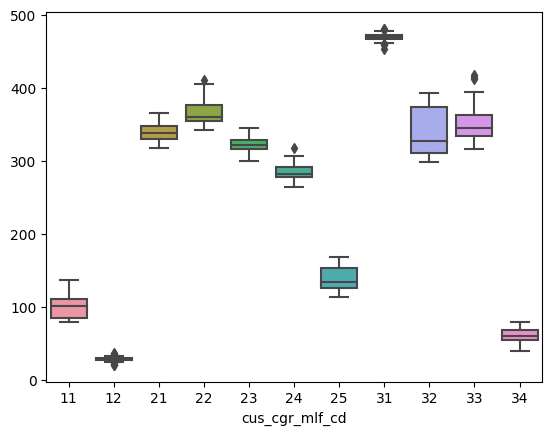

In [142]:
import seaborn as sns
sns.boxplot(account_ratio_var_by_time_and_class)

<Axes: xlabel='bse_dt'>

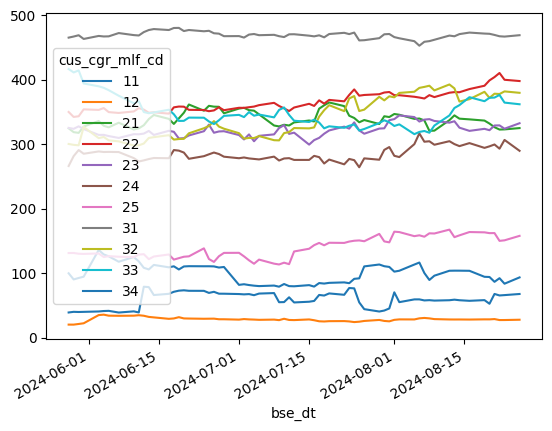

In [143]:
account_ratio_var_by_time_and_class.plot()

데이터간 차이가 존재하고 12번 중간분류가 var이 가장 적음

var이 가장 작다는 것은 12번 그룹의 전체 투자 형태를 보면 잘 분산 투자 했다는 것을 알 수 있다. 

<Axes: xlabel='cus_cgr_mlf_cd'>

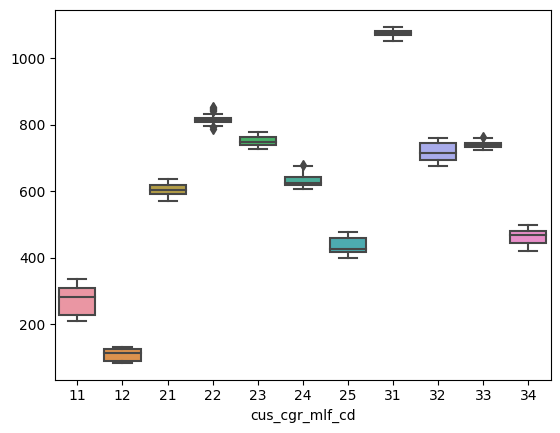

In [144]:
import seaborn as sns
sns.boxplot(investment_ratio_var_by_time_and_class)

<Axes: xlabel='bse_dt'>

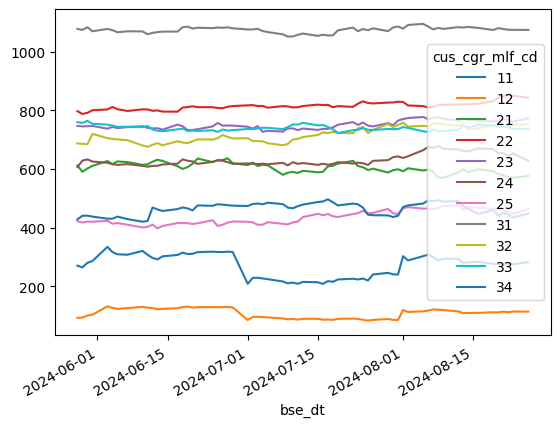

In [145]:
investment_ratio_var_by_time_and_class.plot()

In [146]:
CUSTOMER['bse_dt'] = pd.to_datetime(CUSTOMER['bse_dt'], format='%Y%m%d')

# 중간 분류 코드와 종목 코드 기준으로 그룹화하여 계좌 비율 및 투자 비율 계산
grouped_by_class_and_stock = CUSTOMER.groupby(['cus_cgr_mlf_cd', 'tck_iem_cd'])

# 각 중간 분류 그룹과 종목별 계좌 비율의 합계 계산
account_ratio_sum = grouped_by_class_and_stock['cus_cgr_act_cnt_rt'].sum().reset_index()

# 각 중간 분류 그룹과 종목별 투자 비율의 합계 계산
investment_ratio_sum = grouped_by_class_and_stock['cus_cgr_ivs_rt'].sum().reset_index()

# 계좌 비율과 투자 비율 데이터를 병합하여 종목별 투자 집중도를 확인
merged_df = pd.merge(account_ratio_sum, investment_ratio_sum, on=['cus_cgr_mlf_cd', 'tck_iem_cd'])
merged_df.columns = ['class_code', 'stock_ticker', 'total_account_ratio', 'total_investment_ratio']

# 각 중간 분류 그룹별로 계좌 비율이 높은 종목 정렬
sorted_by_account_ratio = merged_df.sort_values(by=['class_code', 'total_account_ratio'], ascending=[True, False])

# 각 중간 분류 그룹별로 투자 비율이 높은 종목 정렬
sorted_by_investment_ratio = merged_df.sort_values(by=['class_code', 'total_investment_ratio'], ascending=[True, False])

In [149]:
merged_df

,class_code,stock_ticker,total_account_ratio,total_investment_ratio
0,11,AA,150.2061,362.6068
1,11,AAL,101.5980,131.7901
2,11,AAN,28.5716,0.7126
3,11,AAOI,282.9503,123.9161
4,11,AAP,44.4444,163.0286
...,...,...,...,...
21809,34,ZM,63.9626,725.2983
21810,34,ZS,182.6485,1954.5137
21811,34,ZTS,37.3853,5.4223
21812,34,ZURA,216.5009,5.1010


In [150]:
CUSTOMER['bse_dt'] = pd.to_datetime(CUSTOMER['bse_dt'], format='%Y%m%d')

# 날짜와 중간 분류 코드, 종목별로 그룹화하여 시계열 분석
grouped_by_time_and_class = CUSTOMER.groupby(['bse_dt', 'cus_cgr_mlf_cd', 'tck_iem_cd'])

# 계좌 비율과 투자 비율의 시계열 분석 (날짜별로 그룹화)
account_ratio_by_time = grouped_by_time_and_class['cus_cgr_act_cnt_rt'].sum().unstack(level='cus_cgr_mlf_cd')
investment_ratio_by_time = grouped_by_time_and_class['cus_cgr_ivs_rt'].sum().unstack(level='cus_cgr_mlf_cd')

In [153]:
account_ratio_by_time

cus_cgr_mlf_cd              11        12       21       22       23       24  \
bse_dt     tck_iem_cd                                                          
2024-05-28 AA           3.2847   96.7153  17.1533  22.2628  25.5474  22.9927   
           AAL          1.1801   98.8199  21.5074  37.9140  23.5249  12.5238   
           AAN          7.1429   92.8571      NaN  42.8571  50.0000   7.1429   
           AAOI        10.0000   90.0000  30.0000  35.0000   5.0000  25.0000   
           AAON            NaN  100.0000      NaN  40.0000  20.0000  40.0000   
...                        ...       ...      ...      ...      ...      ...   
2024-08-26 ZUO          7.1429   92.8571  35.7143  28.5714  14.2857  14.2857   
           ZURA            NaN  100.0000   4.0000  28.0000  28.0000  24.0000   
           ZVRA         3.0612   96.9388  21.4286  47.9592  21.4286   5.1020   
           ZYME         4.3478   95.6522  26.0870  34.7826  21.7391  13.0435   
           ZYXI        14.2857   85.7143  14.2857  57.1429  14.2857  14.2857   

cus_cgr_mlf_cd              25       31       32       33      34  
bse_dt     tck_iem_cd                                              
2024-05-28 AA          12.0438  56.2044  21.8978  20.8029  1.0949  
           AAL          4.5299  71.1077  19.2615   9.4024  0.1903  
           AAN             NaN  71.4286  14.2857  14.2857     NaN  
           AAOI         5.0000  65.0000  10.0000  25.0000     NaN  
           AAON            NaN  60.0000      NaN  40.0000     NaN  
...                        ...      ...      ...      ...     ...  
2024-08-26 ZUO          7.1429  64.2857  35.7143      NaN     NaN  
           ZURA        16.0000  68.0000  16.0000  16.0000     NaN  
           ZVRA         4.0816  87.7551  10.2041   2.0408     NaN  
           ZYME         4.3478  69.5652  13.0435  17.3913     NaN  
           ZYXI            NaN  85.7143  14.2857      NaN     NaN  

[150986 rows x 11 columns]

In [158]:
CUSTOMER[CUSTOMER['tck_iem_cd'] == 'AA'].sort_values('bse_dt')

,bse_dt,tck_iem_cd,cus_cgr_llf_cd,cus_cgr_mlf_cd,cus_cgr_act_cnt_rt,cus_cgr_ivs_rt
634713,2024-05-28,AA,2,21,17.1533,8.2873
634622,2024-05-28,AA,3,34,1.0949,6.7219
634623,2024-05-28,AA,3,33,20.8029,54.3508
634616,2024-05-28,AA,3,31,56.2044,17.0235
634708,2024-05-28,AA,2,22,22.2628,13.2942
...,...,...,...,...,...,...
634431,2024-08-26,AA,3,31,59.6567,28.0442
634428,2024-08-26,AA,1,12,97.4249,98.1027
634427,2024-08-26,AA,1,11,2.5751,1.8973
634313,2024-08-26,AA,2,25,9.4421,15.4516
